In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
try:
    SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [ ]:
# Load CSV data
df = pd.read_csv("n-gram_youtube_comments.csv")


In [ ]:
# Sentiment analysis
def vader_scores(text: str):
    return sia.polarity_scores(text)

scores = df['comment'].apply(vader_scores).apply(pd.Series)
df = pd.concat([df, scores], axis=1)


# Map compound score → sentiment label
def label_from_compound(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df['sentiment_label'] = df['compound'].apply(label_from_compound)


In [ ]:
 # Aggregate insights
label_share = (df["sentiment_label"].value_counts(normalize=True) * 100).round(2)
avg_compound = df["compound"].mean()

print("=== Aggregate ===")
print("Distribution (%):")
print(label_share)
print("Average compound:", round(avg_compound, 4))

In [ ]:
# Top most positive/negative examples
top_pos = df.nlargest(5, "compound")[["comment", "compound"]]
top_neg = df.nsmallest(5, "compound")[["comment", "compound"]]

print("\nTop positive examples:")
print(top_pos.to_string(index=False))
print("\nTop negative examples:")
print(top_neg.to_string(index=False))

In [30]:
# Word-level analysis (Top tokens & bigrams per sentiment)
def top_ngrams(texts, ngram_range=(1,1), top_k=20):
    vec = CountVectorizer(stop_words="english", lowercase=True,
                          ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = freqs.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": vocab[order], "count": freqs[order]})

pos_texts = df.loc[df["sentiment_label"]=="positive", "comment"]
neg_texts = df.loc[df["sentiment_label"]=="negative", "comment"]

top_pos_unigrams = top_ngrams(pos_texts, (1,1), top_k=20)
top_neg_unigrams = top_ngrams(neg_texts, (1,1), top_k=20)

top_pos_bigrams  = top_ngrams(pos_texts, (2,2), top_k=20)
top_neg_bigrams  = top_ngrams(neg_texts, (2,2), top_k=20)

top_pos_threegrams  = top_ngrams(pos_texts, (3,3), top_k=20)
top_neg_threegrams  = top_ngrams(neg_texts, (3,3), top_k=20)

top_pos_fourgrams  = top_ngrams(pos_texts, (4,4), top_k=20)
top_neg_fourgrams  = top_ngrams(neg_texts, (4,4), top_k=20)

print("\nTop positive unigrams:\n", top_pos_unigrams.to_string(index=False))


Top positive unigrams:
   ngram  count
   game   7412
  lying   6831
   like   5740
     im   4553
   just   3221
   love   3102
   good   3088
   song   2258
   mark   1996
  video   1929
amazing   1914
  great   1894
 really   1868
   best   1817
   play   1800
   time   1529
   dont   1433
  looks   1427
    end   1398
   film   1373


In [31]:
print("\nTop negative unigrams:\n", top_neg_unigrams.to_string(index=False))


Top negative unigrams:
  ngram  count
  game   2733
  just   1699
    im   1579
  like   1112
 lying    944
  shit    849
  dont    790
  mark    702
  make    693
people    672
  fuck    629
  time    545
   bad    544
  damn    525
   man    525
  dick    522
  song    519
really    488
 video    481
  know    467


In [32]:
print("\nTop positive bigrams:\n", top_pos_bigrams.to_string(index=False))


Top positive bigrams:
           ngram  count
       im lying   1940
    lying lying   1336
        end end    866
       lying im    663
     looks like    582
     short film    550
glory arstotzka    362
      feel like    341
stanley parable    339
     cd projekt    302
      play game    285
     video game    273
 cyberpunk 2077    266
      dont know    264
    projekt red    259
       ive seen    233
      love game    224
 elevator music    217
   broom closet    200
   blade runner    198


In [18]:
print("\nTop negative bigrams:\n", top_neg_bigrams.to_string(index=False))


Top negative bigrams:
          ngram  count
      im lying    206
     holy shit    170
    learn game    166
   wanna learn    166
    make quick    166
      rap game    165
    slowly hit    165
    pimpin rap    164
     hit tempo    164
     yeah took    163
   game talkin    163
     dick make    163
    tempo just    163
bitches suckin    162
   talkin shit    162
   game slowly    162
     pimp hoes    162
     dick yeah    162
   suckin dick    162
  dick bitches    162


In [19]:
print("\nTop positive threegrams:\n", top_pos_threegrams.to_string(index=False))


Top positive threegrams:
                     ngram  count
        lying lying lying   1239
              end end end    826
              im lying im    572
           lying im lying    541
           cd projekt red    244
              yes yes yes    137
           cd project red    114
      broom closet ending     97
             ive im lying     94
        play beat driving     60
         people play beat     60
     dont suckplease dont     58
          makes feel like     57
       got motivated went     54
          best short film     54
       motivated went gym     54
   dancing elevator music     52
       went gym listening     52
gym listening masterpiece     52
         reps nerves body     51


In [20]:
print("\nTop negative threerams:\n", top_neg_threegrams.to_string(index=False))


Top negative threerams:
               ngram  count
   wanna learn game    166
    pimpin rap game    164
   slowly hit tempo    164
  learn game talkin    163
     hit tempo just    163
    game slowly hit    162
   game talkin shit    162
    dick make quick    162
     dick yeah took    162
    rap game slowly    162
dick bitches suckin    161
   suckin dick make    161
    make quick dick    161
 tempo just bitches    161
    quick dick yeah    161
bitches suckin dick    161
 niggas wanna learn    158
  just bitches tame    158
 nigga dick bitches    157
  just victim chose    155


In [21]:
print("\nTop positive fourrams:\n", top_pos_fourgrams.to_string(index=False))


Top positive fourrams:
                           ngram  count
        lying lying lying lying   1193
                end end end end    801
              im lying im lying    534
              lying im lying im    517
                yes yes yes yes    121
       people play beat driving     60
         got motivated went gym     54
   motivated went gym listening     52
 went gym listening masterpiece     52
       excited reps nerves body     51
    playlist got motivated went     50
    song playlist got motivated     50
  gym listening masterpiece gym     50
comments thoughts writing hands     49
            mats gym shoes play     49
  thoughts writing hands typing     49
       including mats gym shoes     49
    listens excited reps nerves     49
  writing hands typing keyboard     49
        added song playlist got     49


In [22]:
print("\nTop negative fourrams:\n", top_neg_fourgrams.to_string(index=False))


Top negative fourrams:
                     ngram  count
  wanna learn game talkin    163
    slowly hit tempo just    163
   pimpin rap game slowly    162
      rap game slowly hit    162
   learn game talkin shit    162
     make quick dick yeah    161
   hit tempo just bitches    161
     quick dick yeah took    161
    game slowly hit tempo    161
 bitches suckin dick make    161
     dick make quick dick    161
 dick bitches suckin dick    161
   suckin dick make quick    160
  niggas wanna learn game    158
  tempo just bitches tame    158
nigga dick bitches suckin    156
   fallin pimpin rap game    148
   hoes fallin pimpin rap    146
  pimp hoes fallin pimpin    146
  hoes niggas wanna learn    139


In [33]:
# Confidence & intensity
def intensity_bucket(c):
    m = abs(c)
    if m >= 0.7:  return "very strong"
    if m >= 0.4:  return "strong"
    if m >= 0.2:  return "moderate"
    if m >  0.0:  return "weak"
    return "neutral/zero"

df["intensity"] = df["compound"].apply(intensity_bucket)

print("\nIntensity distribution (%):")
print((df["intensity"].value_counts(normalize=True)*100).round(2))


Intensity distribution (%):
intensity
neutral/zero    42.65
strong          26.56
very strong     12.73
moderate        12.33
weak             5.73
Name: proportion, dtype: float64


In [34]:
# Advanced modeling (Topics)
# LDA topics -> then average sentiment per topic
topic_vec = CountVectorizer(stop_words="english", lowercase=True, min_df=5, max_df=0.5)
X = topic_vec.fit_transform(df["comment"])

n_topics = 8  
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
topic_dist = lda.fit_transform(X)            # shape: (n_docs, n_topics)
df["topic"] = topic_dist.argmax(axis=1)      # dominant topic per comment

# Show top words per topic
terms = np.array(topic_vec.get_feature_names_out())
def top_words_for_topic(topic_idx, top_k=12):
    comp = lda.components_[topic_idx]
    return terms[comp.argsort()[::-1][:top_k]]

print("\n=== Topics & average sentiment ===")
topic_summary = []
for k in range(n_topics):
    words = ", ".join(top_words_for_topic(k, 10))
    avg_c = df.loc[df["topic"]==k, "compound"].mean()
    cnt   = (df["topic"]==k).sum()
    topic_summary.append((k, cnt, round(avg_c, 4), words))
topic_df = pd.DataFrame(topic_summary, columns=["topic","n","avg_compound","top_words"])
print(topic_df.to_string(index=False))


=== Topics & average sentiment ===
 topic     n  avg_compound                                                              top_words
     0 22653        0.1269       game, like, just, really, dont, looks, people, good, games, play
     1  8397        0.2154           amazing, jim, good, game, red, cd, fucking, nice, shit, work
     2 10362        0.1831       just, great, video, good, like, papers, god, job, film, watching
     3  9292        0.2600             lying, im, end, bucket, movie, game, make, film, just, ive
     4 13608        0.2190 song, mark, music, elevator, love, stanley, like, just, best, narrator
     5 10499        0.0631       years, trailer, 2077, jorji, oh, cyberpunk, man, wait, gta, game
     6  8613        0.0445                     не, это, что, на, glory, фильм, как, очень, за, но
     7  6661        0.0368             sigma, que, la, song, el, 2024, closet, broom, ending, die


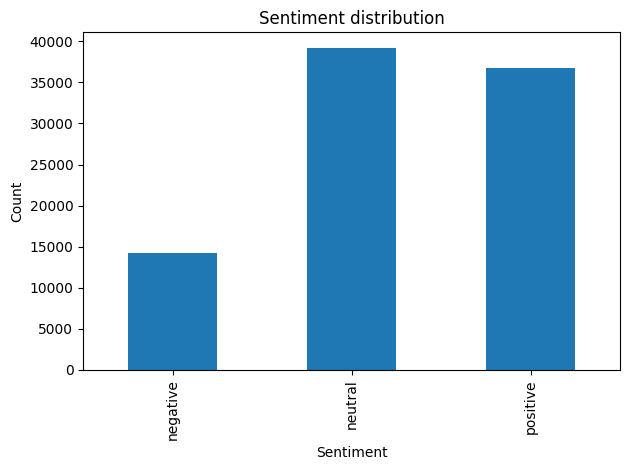

In [11]:
# Visualization (Matplotlib)
label_order = ["negative","neutral","positive"]
label_counts = df["sentiment_label"].value_counts().reindex(label_order, fill_value=0)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

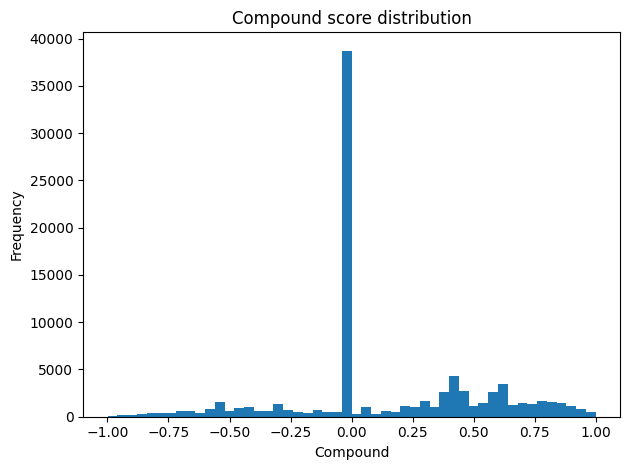

In [12]:
# Histohgram
plt.figure()
df["compound"].plot(kind="hist", bins=50)
plt.title("Compound score distribution")
plt.xlabel("Compound")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

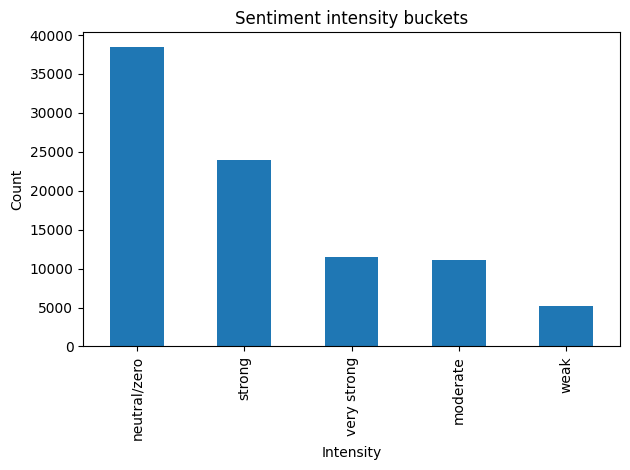

In [13]:
# Bar
plt.figure()
df["intensity"].value_counts().plot(kind="bar")
plt.title("Sentiment intensity buckets")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [14]:
# Save results
df.to_csv("sentiment_youtube_comments.csv", index=False)

print("\nSaved: sentiment_youtube_comments.csv")
print(df['sentiment_label'].value_counts())


Saved: sentiment_youtube_comments.csv
sentiment_label
neutral     39138
positive    36764
negative    14183
Name: count, dtype: int64
